Load all the necessary packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## SKLEARN
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso, PoissonRegressor, ElasticNet
from sklearn.model_selection import KFold, RepeatedKFold, GridSearchCV, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, QuantileTransformer, FunctionTransformer, PolynomialFeatures

## Starting with the scaled totals.

I'll drop the Population, Total and Female_Population columns.



In [2]:
df = pd.read_csv("..\\data\\merged_data_sets\\merged_data_scaled_totals.csv")
df.info()
#df.drop(columns= ["Population","Total", "Female_Population"], inplace=True)
numerical_columns = [c for c in df.columns[3:] if c != "Births"]
y_full = df.Maternal_Mortality_Rate.values
X_full = df[numerical_columns]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 53 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   State                                   170 non-null    object 
 1   Year                                    170 non-null    int64  
 2   Maternal_Mortality_Rate                 170 non-null    float64
 3   $10,000 to $14,999                      170 non-null    float64
 4   $100,000 to $149,999                    170 non-null    float64
 5   $15,000 to $24,999                      170 non-null    float64
 6   $150,000 to $199,999                    170 non-null    float64
 7   $200,000 or more                        170 non-null    float64
 8   $25,000 to $34,999                      170 non-null    float64
 9   $35,000 to $49,999                      170 non-null    float64
 10  $50,000 to $74,999                      170 non-null    float6

### Train Test Split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size= .2, shuffle=True, random_state=1029)
df_train = X_train
X_train = X_train.values


### Some visualizations


In [4]:
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(100, 80))
axes = axes.flatten()
for i,ax in enumerate(axes):
    ax.scatter(X_train[:,i], y_train, s = 350)
    ax.set_title(df_train.columns[i])
plt.tight_layout()

It looks like some of these are highly correlated while some are note at all!

###  Linear Regression

In [5]:
cv_classes = 4
n_repeats = 10
rkf = RepeatedKFold(n_splits=cv_classes, n_repeats=n_repeats, random_state=120)

model1 = LinearRegression()
model2 = Pipeline([('scale', StandardScaler()), ('lin_reg', LinearRegression())])

linear_reg_errors = {"mse":[], "mae":[], "mse_relu":[], "mae_relu":[]}
scal_linear_reg_errors = {"mse":[], "mae":[], "mse_relu":[], "mae_relu":[]}

ReLU = lambda x: x*((x>=0)*1)

for train_ind, test_ind  in rkf.split(X_train, y_train):
    ### Create Validation Sets
    x_tr = X_train[train_ind]
    y_tr = y_train[train_ind]
    x_val = X_train[test_ind]
    y_val = y_train[test_ind]

    ### Fit Models
    model1.fit(x_tr, y_tr)
    model2.fit(x_tr,y_tr)

    ### Predict Model
    y_pred1 = model1.predict(x_val)
    y_pred2 = model2.predict(x_val)
    y_pred1_relu = ReLU(y_pred1)
    y_pred2_relu = ReLU(y_pred2)


    ### Errors

    linear_reg_errors["mse"].append(np.linalg.norm(y_pred1-y_val))
    linear_reg_errors["mae"].append(np.linalg.norm(y_pred1-y_val,ord = 1))
    linear_reg_errors["mse_relu"].append(np.linalg.norm(y_pred1_relu-y_val))
    linear_reg_errors["mae_relu"].append(np.linalg.norm(y_pred1_relu-y_val,ord = 1))
    scal_linear_reg_errors["mse"].append(np.linalg.norm(y_pred2-y_val))
    scal_linear_reg_errors["mae"].append(np.linalg.norm(y_pred2-y_val,ord = 1))
    scal_linear_reg_errors["mse_relu"].append(np.linalg.norm(y_pred2_relu-y_val))
    scal_linear_reg_errors["mae_relu"].append(np.linalg.norm(y_pred2_relu-y_val,ord = 1))

print("-----")
print(f"The Error for linear regression on {cv_classes}-fold cross-validation with {n_repeats} repetitions is ")
print("MSE Error\t| MAE Error\t|\tReLU  \t | \tScaled?")
print(f"{np.round(np.mean(linear_reg_errors['mse']),2)} \t\t| {np.round(np.mean(linear_reg_errors['mae']),2)} \t\t| \t No \t\t | \t No \t")
print(f"{np.round(np.mean(linear_reg_errors['mse_relu']),2)} \t\t| {np.round(np.mean(linear_reg_errors['mae_relu']),2)} \t\t| \t Yes \t | \t No \t")
print(f"{np.round(np.mean(scal_linear_reg_errors['mse']),2)} \t\t|  {np.round(np.mean(scal_linear_reg_errors['mae']),2)} \t\t| \t No \t\t | \t Yes \t")
print(f"{np.round(np.mean(scal_linear_reg_errors['mse_relu']),2)}\t\t|  {np.round(np.mean(scal_linear_reg_errors['mae_relu']),2)} \t\t| \t Yes \t | \t Yes \t")



-----
The Error for linear regression on 4-fold cross-validation with 10 repetitions is 
MSE Error	| MAE Error	|	ReLU  	 | 	Scaled?
2052.84 		| 3145.39 		| 	 No 		 | 	 No 	
2052.53 		| 3144.49 		| 	 Yes 	 | 	 No 	
2052.84 		|  3145.39 		| 	 No 		 | 	 Yes 	
2052.53		|  3144.49 		| 	 Yes 	 | 	 Yes 	


### Poisson Regression

In [6]:
cv_classes = 4
n_repeats = 10
rkf = RepeatedKFold(n_splits=cv_classes, n_repeats=n_repeats, random_state=120)

model1 = PoissonRegressor(max_iter=100000)
model2 = Pipeline([('scale', StandardScaler()), ('poi_reg', PoissonRegressor(max_iter=100000, alpha = 0.01))])

poi_reg_errors = {"mse":[], "mae":[], "mse_relu":[], "mae_relu":[]}
scal_poi_reg_errors = {"mse":[], "mae":[], "mse_relu":[], "mae_relu":[]}

ReLU = lambda x: x*((x>=0)*1)

for train_ind, test_ind  in rkf.split(X_train, y_train):
    ### Create Validation Sets
    x_tr = X_train[train_ind]
    y_tr = y_train[train_ind]
    x_val = X_train[test_ind]
    y_val = y_train[test_ind]

    ### Fit Models
    model1.fit(x_tr, y_tr)
    model2.fit(x_tr,y_tr)

    ### Predict Model
    y_pred1 = model1.predict(x_val)
    y_pred2 = model2.predict(x_val)
    y_pred1_relu = ReLU(y_pred1)
    y_pred2_relu = ReLU(y_pred2)


    ### Errors

    poi_reg_errors["mse"].append(np.linalg.norm(y_pred1-y_val))
    poi_reg_errors["mae"].append(np.linalg.norm(y_pred1-y_val,ord = 1))
    scal_poi_reg_errors["mse"].append(np.linalg.norm(y_pred2-y_val))
    scal_poi_reg_errors["mae"].append(np.linalg.norm(y_pred2-y_val,ord = 1))
    
print("-----")
print(f"The Error for linear regression on {cv_classes}-fold cross-validation with {n_repeats} repetitions is ")
print("MSE Error\t| MAE Error\t|\tScaled?")
print(f"{np.round(np.mean(poi_reg_errors['mse']),2)} \t\t| {np.round(np.mean(poi_reg_errors['mae']),2)} \t\t| \t No \t")
print(f"{np.round(np.mean(scal_poi_reg_errors['mse']),2)} \t\t|  {np.round(np.mean(scal_poi_reg_errors['mae']),2)} \t\t| \t Yes \t")


-----
The Error for linear regression on 4-fold cross-validation with 10 repetitions is 
MSE Error	| MAE Error	|	Scaled?
61.74 		| 274.44 		| 	 No 	
596.95 		|  1045.54 		| 	 Yes 	


### Lasso

In [7]:
cv_classes = 4
n_repeats = 10
rkf = RepeatedKFold(n_splits=cv_classes, n_repeats=n_repeats, random_state=120)

model1 = Lasso(max_iter=100000, alpha = .01)
model2 = Pipeline([('scale', StandardScaler()), ('poi_reg', Lasso(max_iter=500000, alpha = .01))])

lasso_reg_errors = {"mse":[], "mae":[], "mse_relu":[], "mae_relu":[]}
scal_lasso_reg_errors = {"mse":[], "mae":[], "mse_relu":[], "mae_relu":[]}

ReLU = lambda x: x*((x>=0)*1)

for train_ind, test_ind  in rkf.split(X_train, y_train):
    ### Create Validation Sets
    x_tr = X_train[train_ind]
    y_tr = y_train[train_ind]
    x_val = X_train[test_ind]
    y_val = y_train[test_ind]

    ### Fit Models
    model1.fit(x_tr, y_tr)
    model2.fit(x_tr,y_tr)

    ### Predict Model
    y_pred1 = model1.predict(x_val)
    y_pred2 = model2.predict(x_val)
    y_pred1_relu = ReLU(y_pred1)
    y_pred2_relu = ReLU(y_pred2)


    ### Errors

    lasso_reg_errors["mse"].append(np.linalg.norm(y_pred1-y_val))
    lasso_reg_errors["mae"].append(np.linalg.norm(y_pred1-y_val,ord = 1))
    lasso_reg_errors["mse_relu"].append(np.linalg.norm(y_pred1_relu-y_val))
    lasso_reg_errors["mae_relu"].append(np.linalg.norm(y_pred1_relu-y_val,ord = 1))
    scal_lasso_reg_errors["mse"].append(np.linalg.norm(y_pred2-y_val))
    scal_lasso_reg_errors["mae"].append(np.linalg.norm(y_pred2-y_val,ord = 1))
    scal_lasso_reg_errors["mse_relu"].append(np.linalg.norm(y_pred2_relu-y_val))
    scal_lasso_reg_errors["mae_relu"].append(np.linalg.norm(y_pred2_relu-y_val,ord = 1))

print("-----")
print(f"The Error for linear regression on {cv_classes}-fold cross-validation with {n_repeats} repetitions is ")
print("MSE Error\t| MAE Error\t|\tScaled?")
print(f"{np.round(np.mean(lasso_reg_errors['mse']),2)} \t\t| {np.round(np.mean(lasso_reg_errors['mae']),2)} \t\t| \t No \t")
print(f"{np.round(np.mean(scal_lasso_reg_errors['mse']),2)} \t\t|  {np.round(np.mean(scal_lasso_reg_errors['mae']),2)} \t\t| \t Yes \t")


-----
The Error for linear regression on 4-fold cross-validation with 10 repetitions is 
MSE Error	| MAE Error	|	Scaled?
62.34 		| 283.09 		| 	 No 	
66.99 		|  306.58 		| 	 Yes 	


### Ridge Regression

In [8]:
cv_classes = 4
n_repeats = 10
rkf = RepeatedKFold(n_splits=cv_classes, n_repeats=n_repeats, random_state=120)

model1 = Ridge(max_iter=100000, alpha = .01)
model2 = Pipeline([('scale', StandardScaler()), ('poi_reg', Ridge(max_iter=500000, alpha = .01))])

ridge_reg_errors = {"mse":[], "mae":[], "mse_relu":[], "mae_relu":[]}
scal_ridge_reg_errors = {"mse":[], "mae":[], "mse_relu":[], "mae_relu":[]}

ReLU = lambda x: x*((x>=0)*1)

for train_ind, test_ind  in rkf.split(X_train, y_train):
    ### Create Validation Sets
    x_tr = X_train[train_ind]
    y_tr = y_train[train_ind]
    x_val = X_train[test_ind]
    y_val = y_train[test_ind]

    ### Fit Models
    model1.fit(x_tr, y_tr)
    model2.fit(x_tr,y_tr)

    ### Predict Model
    y_pred1 = model1.predict(x_val)
    y_pred2 = model2.predict(x_val)
    y_pred1_relu = ReLU(y_pred1)
    y_pred2_relu = ReLU(y_pred2)


    ### Errors

    ridge_reg_errors["mse"].append(np.linalg.norm(y_pred1-y_val))
    ridge_reg_errors["mae"].append(np.linalg.norm(y_pred1-y_val,ord = 1))
    scal_ridge_reg_errors["mse"].append(np.linalg.norm(y_pred2-y_val))
    scal_ridge_reg_errors["mae"].append(np.linalg.norm(y_pred2-y_val,ord = 1))
print("-----")
print(f"The Error for linear regression on {cv_classes}-fold cross-validation with {n_repeats} repetitions is ")
print("MSE Error\t| MAE Error\t|\tScaled?")
print(f"{np.round(np.mean(ridge_reg_errors['mse']),2)} \t\t| {np.round(np.mean(ridge_reg_errors['mae']),2)} \t\t| \t No \t")
print(f"{np.round(np.mean(scal_ridge_reg_errors['mse']),2)} \t\t|  {np.round(np.mean(scal_ridge_reg_errors['mae']),2)} \t\t| \t Yes \t")


-----
The Error for linear regression on 4-fold cross-validation with 10 repetitions is 
MSE Error	| MAE Error	|	Scaled?
61.51 		| 283.56 		| 	 No 	
143.99 		|  430.36 		| 	 Yes 	


# Comparison:
It looks like linear regression, Lasso and Ridge regression do roughly the same and Poisson regression does worse. 

The MSE for scaled Lasso and Ridge do better. So let's look at each for various choices of the regularization $\alpha$.

In [9]:
cv_classes = 4
n_repeats = 50
rkf = RepeatedKFold(n_splits=cv_classes, n_repeats=n_repeats, random_state=120)


num_values = 40
alpha_choices = np.linspace(20/num_values,20,num_values)

cv_mean_lasso = []
cv_mean_ridge = []
cv_std_lasso = []
cv_std_ridge = []

for alpha in alpha_choices:
    pipe_lasso = Pipeline([('scale',StandardScaler()), ('regression',Lasso(max_iter = 400000,alpha = alpha))])
    pipe_ridge = Pipeline([('scale',StandardScaler()), ('regression',Ridge(max_iter = 400000,alpha = alpha))])
    cv_scores1 = cross_val_score(estimator=pipe_lasso, X = X_train, y = y_train, cv = rkf, scoring='neg_mean_squared_error')
    cv_scores2 = cross_val_score(estimator=pipe_ridge, X = X_train, y = y_train, cv = rkf, scoring='neg_mean_squared_error')
    cv_mean_lasso.append(-cv_scores1.mean())
    cv_mean_ridge.append(-cv_scores2.mean())
    cv_std_lasso.append(cv_scores1.std())
    cv_std_ridge.append(cv_scores2.std())
    """
    print(f"The average error for Lasso with alpha = {np.round(alpha,2)} is {np.round(-cv_scores1.mean(),2)}.")
    print(f"The average error for Ridge with alpha = {np.round(alpha,2)} is {np.round(-cv_scores2.mean(),2)}.")
    print(f"The standard deviation for Lasso with alpha = {np.round(alpha,2)} is {np.round(cv_scores1.std(),2)}.")
    print(f"The standard deviation for Ridge with alpha = {np.round(alpha,2)} is {np.round(cv_scores2.std(),2)}.")
    """



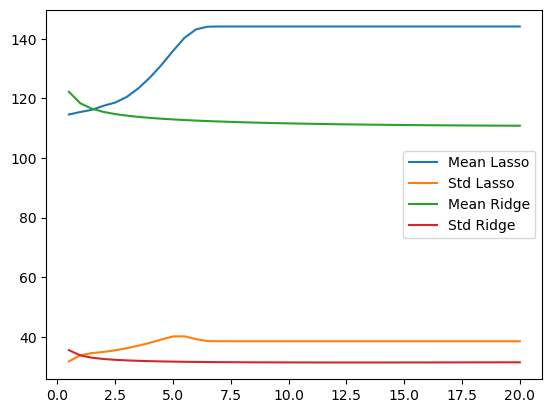

The best Lasso is alpha = 0.5 and the value is 114.61.
The best Ridge is alpha = 20.0 and the values is 111.0.


In [10]:
plt.plot(alpha_choices, cv_mean_lasso, label = "Mean Lasso")
plt.plot(alpha_choices, cv_std_lasso,label =  "Std Lasso")
plt.plot(alpha_choices, cv_mean_ridge, label = "Mean Ridge")
plt.plot(alpha_choices, cv_std_ridge, label = "Std Ridge")
plt.legend()
plt.show()
print(f"The best Lasso is alpha = {np.round(alpha_choices[np.argmin(cv_mean_lasso)],2)} and the value is {np.round(np.min(cv_mean_lasso),2)}.")
print(f"The best Ridge is alpha = {np.round(alpha_choices[np.argmin(cv_mean_ridge)],2)} and the values is {np.round(np.min(cv_mean_ridge))}.")

In [11]:
cv_classes = 4
n_repeats = 10
rkf = RepeatedKFold(n_splits=cv_classes, n_repeats=n_repeats, random_state=120)
pipe_linear = Pipeline([('scale',StandardScaler()), ('regression',LinearRegression())])
cv_scores = cross_val_score(estimator=pipe_linear, X = X_train, y = y_train, cv = rkf, scoring='neg_mean_squared_error')

print(f"The average error for Linear Regression is {np.round(-cv_scores.mean(),2)}.")

print(f"The standard deviation for Linear Regression is {np.round(cv_scores.std(),2)}.")

The average error for Linear Regression is 1054673.68.
The standard deviation for Linear Regression is 3355670.07.


### Prelim Takeaways.
It looks like the best choices for both Lasso and Ridge appear whenever the regularization parameter $\alpha$ is small. They are both the most accurate and least variable.

# Non-linear features


In [12]:
cv_classes = 4
n_repeats = 10
rkf = RepeatedKFold(n_splits=cv_classes, n_repeats=n_repeats, random_state=120)

pipe_lasso_non_linear = Pipeline([
    ('scale', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('lasso', Lasso(max_iter = 100000, alpha = 1))
])

cv_scores = cross_val_score(estimator=pipe_lasso_non_linear, X = X_train, y = y_train, cv = rkf, scoring='neg_mean_squared_error')

print(f"The average error for Linear Regression wtih degree 2 features is {np.round(-cv_scores.mean(),2)}.")
print(f"The standard deviation for Linear Regression with degree 2 featuers is {np.round(cv_scores.std(),2)}.")


The average error for Linear Regression wtih degree 2 features is 98.19.
The standard deviation for Linear Regression with degree 2 featuers is 32.85.


In [13]:
cv_classes = 4
n_repeats = 10
rkf = RepeatedKFold(n_splits=cv_classes, n_repeats=n_repeats, random_state=120)


spacing = 10
alpha_choices = np.linspace(1/spacing,2,spacing)

cv_mean_lasso_non_linear = []
cv_std_lasso_non_linear = []
cv_mean_ridge_non_linear = []
cv_std_ridge_non_linear = []

for alpha in alpha_choices:
    pipe_lasso_non_linear = Pipeline([('scale',StandardScaler()), ('poly', PolynomialFeatures(degree = 2)),('regression',Lasso(max_iter = 40000,alpha = alpha))])
    pipe_ridge_non_linear = Pipeline([('scale',StandardScaler()), ('poly', PolynomialFeatures(degree = 2)),('regression',Ridge(max_iter = 40000,alpha = alpha))])
    cv_scoresLassoPoly = cross_val_score(estimator=pipe_lasso_non_linear, X = X_train, y = y_train, cv = rkf, scoring='neg_mean_squared_error')
    cv_scoresRidgePoly = cross_val_score(estimator=pipe_ridge_non_linear, X = X_train, y = y_train, cv = rkf, scoring='neg_mean_squared_error')
    cv_mean_lasso_non_linear.append(-cv_scoresLassoPoly.mean())
    cv_std_lasso_non_linear.append(cv_scoresLassoPoly.std())
    cv_mean_ridge_non_linear.append(-cv_scoresRidgePoly.mean())
    cv_std_ridge_non_linear.append(cv_scoresRidgePoly.std())
    """
    print(f"The average error for Lasso with alpha = {np.round(alpha,2)} is {np.round(-cv_scores1.mean(),2)}.")
    print(f"The average error for Ridge with alpha = {np.round(alpha,2)} is {np.round(-cv_scores2.mean(),2)}.")
    print(f"The standard deviation for Lasso with alpha = {np.round(alpha,2)} is {np.round(cv_scores1.std(),2)}.")
    print(f"The standard deviation for Ridge with alpha = {np.round(alpha,2)} is {np.round(cv_scores2.std(),2)}.")
    """



97.89112146890929
122.43175874212088


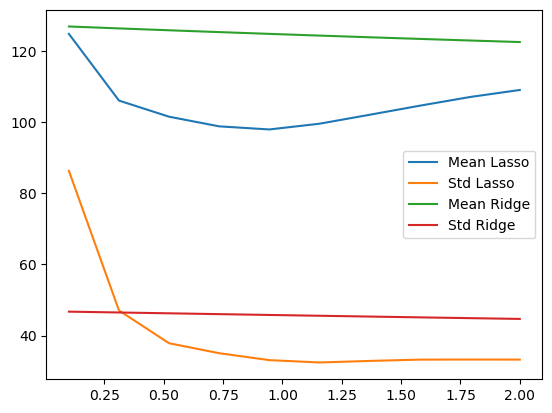

In [14]:
plt.plot(alpha_choices, cv_mean_lasso_non_linear, label = "Mean Lasso")
plt.plot(alpha_choices, cv_std_lasso_non_linear,label =  "Std Lasso")
plt.plot(alpha_choices, cv_mean_ridge_non_linear, label = "Mean Ridge")
plt.plot(alpha_choices, cv_std_ridge_non_linear,label =  "Std Ridge")
print(min(cv_mean_lasso_non_linear))
print(min(cv_mean_ridge_non_linear))
plt.legend()

In [15]:
cv_classes = 4
n_repeats = 10
rkf = RepeatedKFold(n_splits=cv_classes, n_repeats=n_repeats, random_state=120)


spacing = 10
alpha_choices = np.linspace(1/spacing,2,spacing)

cv_mean_lasso_non_linear = []
cv_std_lasso_non_linear = []
cv_mean_ridge_non_linear = []
cv_std_ridge_non_linear = []

for alpha in alpha_choices:
    pipe_lasso_non_linear = Pipeline([('log', FunctionTransformer(lambda x:np.log(1+np.sqrt(x)))), ('scale',StandardScaler()), ('poly', PolynomialFeatures(degree = 2)),('regression',Lasso(max_iter = 40000,alpha = alpha))])
    pipe_ridge_non_linear = Pipeline([('log', FunctionTransformer(lambda x:np.log(1+np.sqrt(x)))), ('scale',StandardScaler()), ('poly', PolynomialFeatures(degree = 2)),('regression',Ridge(max_iter = 40000,alpha = alpha))])
    cv_scoresLassoPoly = cross_val_score(estimator=pipe_lasso_non_linear, X = X_train, y = y_train, cv = rkf, scoring='neg_mean_squared_error')
    cv_scoresRidgePoly = cross_val_score(estimator=pipe_ridge_non_linear, X = X_train, y = y_train, cv = rkf, scoring='neg_mean_squared_error')
    cv_mean_lasso_non_linear.append(-cv_scoresLassoPoly.mean())
    cv_std_lasso_non_linear.append(cv_scoresLassoPoly.std())
    cv_mean_ridge_non_linear.append(-cv_scoresRidgePoly.mean())
    cv_std_ridge_non_linear.append(cv_scoresRidgePoly.std())



96.70422230351035
186.35387380695468


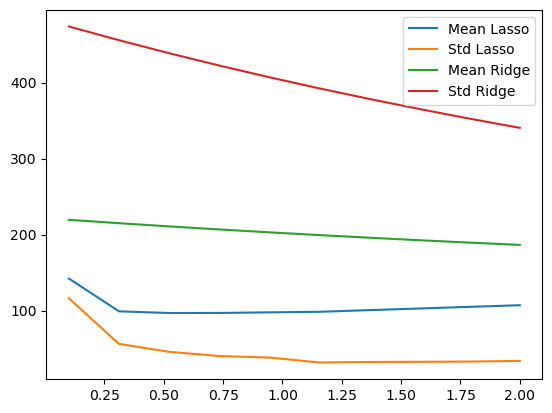

In [16]:
plt.plot(alpha_choices, cv_mean_lasso_non_linear, label = "Mean Lasso")
plt.plot(alpha_choices, cv_std_lasso_non_linear,label =  "Std Lasso")
plt.plot(alpha_choices, cv_mean_ridge_non_linear, label = "Mean Ridge")
plt.plot(alpha_choices, cv_std_ridge_non_linear,label =  "Std Ridge")
print(min(cv_mean_lasso_non_linear))
print(min(cv_mean_ridge_non_linear))
plt.legend()

### Summary: 
It looks like these do the best for cross-validation purposes:
1) StandardardScaler()
2) Lasso() or Ridge()

The best MSE for Lasso() was $\approx 181$ when $\alpha\approx 0.28$.
The best MSE for Ridge() was $\approx 185$ when $\alpha\approx 1.56$.

## Lasso With More Detail

In [17]:
cv_classes = 5
n_repeats = 50
rkf = RepeatedKFold(n_splits=cv_classes, n_repeats=n_repeats, random_state=168)

param_grid = {'lasso__alpha': list(np.linspace(0.01, .9, 50))}
lasso_model = Pipeline([("scale", StandardScaler()), ("lasso", Lasso(max_iter=4000))])
grid_search_lasso = GridSearchCV(estimator = lasso_model, param_grid = param_grid, scoring = 'neg_mean_squared_error', cv = rkf)
grid_search_lasso.fit(X_train,y_train)
best_lasso = grid_search_lasso.best_estimator_.named_steps['lasso']
coeffs_lasso = best_lasso.coef_
print("Best parameters:", grid_search_lasso.best_params_)
print("Best score:", -grid_search_lasso.best_score_)




c:\Users\david\anaconda3\envs\erdos_spring_2025\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.066e+01, tolerance: 1.679e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\david\anaconda3\envs\erdos_spring_2025\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.763e+01, tolerance: 1.569e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\david\anaconda3\envs\erdos_spring_2025\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or

Best parameters: {'lasso__alpha': np.float64(0.11897959183673469)}
Best score: 108.83882121194502


## Ridge with more detail

In [18]:
cv_classes = 5
n_repeats = 50
rkf = RepeatedKFold(n_splits=cv_classes, n_repeats=n_repeats, random_state=168)

param_grid = {'ridge__alpha': list(np.linspace(9, 11, 40))}
lasso_model = Pipeline([("scale", StandardScaler()), ("ridge", Ridge(max_iter = 4000))])
grid_search_ridge = GridSearchCV(estimator = lasso_model, param_grid = param_grid, scoring = 'neg_mean_squared_error', cv = rkf)
grid_search_ridge.fit(X_train,y_train)
best_ridge = grid_search_ridge.best_estimator_.named_steps['ridge']
coeffs_ridge = best_ridge.coef_
print("Best parameters:", grid_search_ridge.best_params_)
print("Best score:", -grid_search_ridge.best_score_)

Best parameters: {'ridge__alpha': np.float64(10.846153846153847)}
Best score: 107.40832867248493


## Elastic Net with more detail

In [19]:
cv_classes = 5
n_repeats = 50
rkf = RepeatedKFold(n_splits=cv_classes, n_repeats=n_repeats, random_state=168)

param_grid = {'elasticnet__alpha': list(np.linspace(0.001, 15, 40)),
              "elasticnet__l1_ratio":[0.25,0.5,0.75]}
elasticnet_model = Pipeline([("scale", StandardScaler()), ("elasticnet", ElasticNet(max_iter = 4000))])
grid_search_elasticnet = GridSearchCV(estimator = elasticnet_model, param_grid = param_grid, scoring = 'neg_mean_squared_error', cv = rkf)
grid_search_elasticnet.fit(X_train,y_train)
best_elasticnet = grid_search_elasticnet.best_estimator_.named_steps['elasticnet']
coeffs_elasticnet = best_elasticnet.coef_
print("Best parameters:", grid_search_elasticnet.best_params_)
print("Best score:", -grid_search_elasticnet.best_score_)

c:\Users\david\anaconda3\envs\erdos_spring_2025\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.437e+00, tolerance: 1.679e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\david\anaconda3\envs\erdos_spring_2025\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.349e+01, tolerance: 1.569e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\david\anaconda3\envs\erdos_spring_2025\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or

Best parameters: {'elasticnet__alpha': np.float64(0.3855897435897436), 'elasticnet__l1_ratio': 0.25}
Best score: 109.18335491938208


In [24]:
coef_df = pd.DataFrame(columns=df_train.columns)
coef_df.loc[0] = [np.abs(np.round(c,2)) for c in coeffs_lasso]
coef_df.loc[1] = [np.abs(np.round(c,2)) for c in coeffs_ridge]
coef_df.loc[2] = [np.abs(np.round(c,2)) for c in coeffs_elasticnet]

coef_df.index = ["Lasso", "Ridge",'ElasticNet']
print(coef_df.transpose().sort_values("Lasso",ascending=False).head(10))
print(coef_df.transpose().sort_values("Ridge",ascending=False).head(10))
print(coef_df.transpose().sort_values("ElasticNet",ascending=False).head(10))


                          Lasso  Ridge  ElasticNet
40Weeks                    9.79   2.94        0.27
41Weeks                    9.17   3.74        1.60
3rdMonthInitialCare        6.63   2.88        1.39
5thMonthInitialCare        4.53   1.78        0.13
Percent_No_Activity        4.02   3.32        2.73
Other_Delivery_Attendant   3.21   2.34        1.48
9thMonthInitialCare        3.13   2.50        1.16
42PlusWeeks                2.85   2.74        1.40
Percent_Obese              2.82   1.24        0.68
NoPrenatalCare             2.50   2.41        1.43
                          Lasso  Ridge  ElasticNet
41Weeks                    9.17   3.74        1.60
Percent_No_Activity        4.02   3.32        2.73
40Weeks                    9.79   2.94        0.27
3rdMonthInitialCare        6.63   2.88        1.39
42PlusWeeks                2.85   2.74        1.40
9thMonthInitialCare        3.13   2.50        1.16
NoPrenatalCare             2.50   2.41        1.43
Other_Delivery_Attendant   3.21

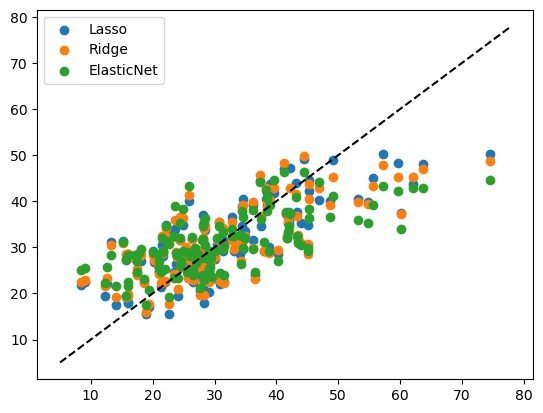

In [21]:
y_pred_lasso = grid_search_lasso.best_estimator_.predict(X_train)
y_pred_ridge = grid_search_ridge.best_estimator_.predict(X_train)
y_pred_elasticnet = grid_search_elasticnet.best_estimator_.predict(X_train)

plt.scatter(y_train, y_pred_lasso, label = "Lasso")
plt.scatter(y_train, y_pred_ridge, label = "Ridge")
plt.scatter(y_train, y_pred_elasticnet, label = "ElasticNet")
plt.legend()
lims = plt.gca().get_xlim()
plt.plot(lims,lims, 'k--')

In [23]:
# Find RSS
rss_lasso = np.linalg.norm(y_pred_lasso - y_train)**2
rss_ridge = np.linalg.norm(y_pred_ridge - y_train)**2
rss_elasticnet = np.linalg.norm(y_pred_elasticnet-y_train)**2
# Normalize: RSS for lin reg is E[RSS] = sigma^2 * (n-p-1) where p is the number of features and sigma is variance of noise
sigma2 = y_train.std()**2
factor = X_train.shape[0]-X_train.shape[1]-1
norm_lasso_error = rss_lasso/(sigma2* factor)
norm_ridge_error = rss_lasso/(sigma2* factor)
norm_elasticnet_error = rss_lasso/(sigma2* factor)

print(f"The best Lasso score scaled by variance is {np.round(norm_lasso_error,3)}.")
print(f"The best Ridge score scaled by variance is {np.round(norm_ridge_error,3)}.")
print(f"The best ElasticNet score scaled by variance is {np.round(norm_elasticnet_error,3)}.")

The best Lasso score scaled by variance is 0.683.
The best Ridge score scaled by variance is 0.683.
The best ElasticNet score scaled by variance is 0.683.


In [34]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


In [33]:
cv_classes = 5
n_repeats = 50
rkf = RepeatedKFold(n_splits=cv_classes, n_repeats=n_repeats, random_state=168)
gradient_boost   = Pipeline([("scale", StandardScaler()), ("boost", GradientBoostingRegressor(loss ='squared_error', learning_rate = 0.01, random_state = 25 ))])
gb_cross_val_score = cross_val_score(estimator=gradient_boost, cv = rkf, scoring='neg_mean_squared_error', X = X_train ,y = y_train)
print(np.mean(gb_cross_val_score))

-104.82423711775412


In [37]:
cv_classes = 5
n_repeats = 50
rkf = RepeatedKFold(n_splits=cv_classes, n_repeats=n_repeats, random_state=168)
rand_for_class   = Pipeline([("scale", StandardScaler()), ("boost", RandomForestRegressor(random_state = 25 ))])
rf_cross_val_score = cross_val_score(estimator=rand_for_class, cv = rkf, scoring='neg_mean_squared_error', X = X_train ,y = y_train)
print(np.mean(rf_cross_val_score))

-83.6257167601063
